# ANALISE DE CRM

A ideia desse projeto e realizar uma analise de dados baseada em um dataset de um CRM exemplo. O dataset pode ser baixado [aqui](https://www.kaggle.com/datasets/carrie1/ecommerce-data?resource=download)

## IMPORT DE PACOTES
Nessa secao, serao importados os pacotes necessarios para realizar uma analise do dataset. Sao eles:
- pandas
- plotly

In [1]:
import pandas
import plotly.express as px
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## IMPORT DATASET

In [2]:
df_crm = pandas.read_csv('../assets/data.csv', encoding= 'unicode_escape')
df_crm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## ORGANIZACAO E LIMPEZA DOS DADOS
Os datasets podem conter dados fora do formato que necessario para a analise e pode conter nulos em alguma coluna devido algum erro na insercao dos dados na ferramenta. Alem disso pode existir outliers que algumas vezes nao fazem sentido analisar por terem sido muito pontuais ou gerados por algum erro sistemico.

In [3]:
df_crm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df_crm_cleaned = df_crm.copy()
df_crm_cleaned['InvoiceDate'] = df_crm_cleaned['InvoiceDate'].astype('datetime64[ns]')
df_crm_cleaned['CustomerID'] = df_crm_cleaned['CustomerID'].astype('str')
df_crm_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df_crm_cleaned['Description'].fillna('Missings' , inplace = True)
df_crm_cleaned[df_crm_cleaned['Description'].str.contains('\w+')]
df_crm_cleaned['Description'] = df_crm_cleaned['Description'].apply(lambda x : x.replace('?',"Missings"))
df_crm_cleaned['Description'] = df_crm_cleaned['Description'].apply(lambda x : x.lower())
df_crm_cleaned.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [6]:
df_crm_cleaned = df_crm_cleaned[~(df_crm['UnitPrice']==0)].sort_values(by = 'UnitPrice')
df_crm_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299984,A563187,B,adjust bad debt,1,2011-08-12 14:52:00,-11062.060,nan,United Kingdom
299983,A563186,B,adjust bad debt,1,2011-08-12 14:51:00,-11062.060,nan,United Kingdom
359871,568200,PADS,pads to match all cushions,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom
279045,561226,PADS,pads to match all cushions,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom
361741,568375,BANK CHARGES,bank charges,1,2011-09-26 17:01:00,0.001,13405.0,United Kingdom
...,...,...,...,...,...,...,...,...
15016,C537630,AMAZONFEE,amazon fee,-1,2010-12-07 15:04:00,13541.330,nan,United Kingdom
43703,C540118,AMAZONFEE,amazon fee,-1,2011-01-05 09:57:00,16453.710,nan,United Kingdom
43702,C540117,AMAZONFEE,amazon fee,-1,2011-01-05 09:55:00,16888.020,nan,United Kingdom
524602,C580605,AMAZONFEE,amazon fee,-1,2011-12-05 11:36:00,17836.460,nan,United Kingdom


In [7]:
df_crm_cleaned = df_crm_cleaned.iloc[2:]
df_crm_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
359871,568200,PADS,pads to match all cushions,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom
279045,561226,PADS,pads to match all cushions,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom
361741,568375,BANK CHARGES,bank charges,1,2011-09-26 17:01:00,0.001,13405.0,United Kingdom
157195,550193,PADS,pads to match all cushions,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom
108088,C545478,D,discount,-720,2011-03-03 11:08:00,0.010,16422.0,United Kingdom


## ANALISE DE DADOS
Toda analise de dados precisa ter um objetivo em mente.

- Which Items Sold More Often
- According to each Country, What is the (Average) Invoice
- From Where The Most Data Comes
- Which Stock_Code Used the most 
- what is the most Year we made money
- On average what is the best month Which we do a great job in it

### Encontrar a Serie Historica de Vendas

In [8]:
df_historical_sales = df_crm[['InvoiceDate', 'Quantity', 'UnitPrice']]
df_historical_sales['TotalValue'] = df_historical_sales['Quantity'] * df_historical_sales['UnitPrice']

df_historical_sales.head()

C:\Users\Guilh\AppData\Local\Temp\ipykernel_3036\2335235470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_historical_sales['TotalValue'] = df_historical_sales['Quantity'] * df_historical_sales['UnitPrice']


,InvoiceDate,Quantity,UnitPrice,TotalValue
0,12/1/2010 8:26,6,2.55,15.30
1,12/1/2010 8:26,6,3.39,20.34
2,12/1/2010 8:26,8,2.75,22.00
3,12/1/2010 8:26,6,3.39,20.34
4,12/1/2010 8:26,6,3.39,20.34


In [9]:
def format_number(x):
    if(x < 10):
        return '0'+str(x)
    else:
        return str(x)

df_historical_sales_month = df_historical_sales
df_historical_sales_month['YearMonth'] = pandas.to_datetime(df_historical_sales_month['InvoiceDate']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=format_number(x.month)))
df_historical_sales_month_result = df_historical_sales_month.groupby('YearMonth')['TotalValue'].sum()
df_plot = df_historical_sales_month_result.to_frame().reset_index().sort_values(by=['YearMonth'])

df_plot


C:\Users\Guilh\AppData\Local\Temp\ipykernel_3036\2902570535.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_historical_sales_month['YearMonth'] = pandas.to_datetime(df_historical_sales_month['InvoiceDate']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=format_number(x.month)))


,YearMonth,TotalValue
0,2010-12,748957.020
1,2011-01,560000.260
2,2011-02,498062.650
3,2011-03,683267.080
4,2011-04,493207.121
5,2011-05,723333.510
6,2011-06,691123.120
7,2011-07,681300.111
8,2011-08,682680.510
9,2011-09,1019687.622


In [10]:
fig = px.line(df_plot, x="YearMonth", y="TotalValue", title='Sales per Month')
fig.show()


### Relacao Produtos e Vendas

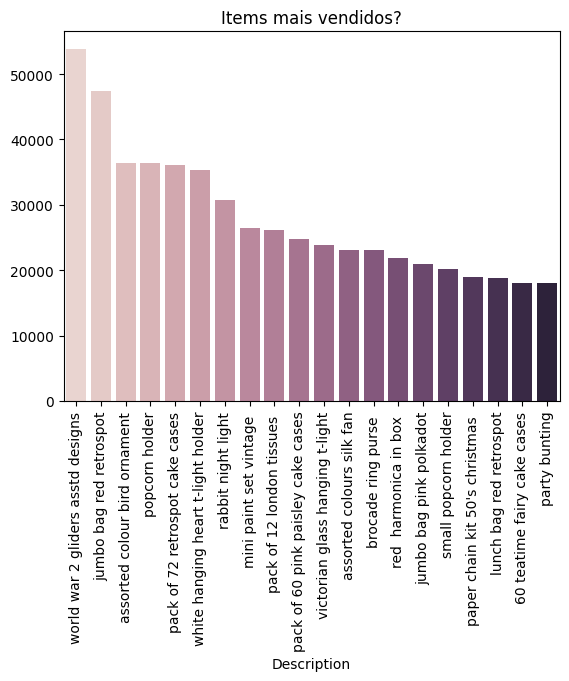

In [11]:
df_relation = df_crm_cleaned.copy()
items = df_relation.groupby('Description')['Quantity'].sum().sort_values(ascending = False)[:20]
sns.barplot(x=items.index, y=items.values, palette=sns.cubehelix_palette(20))
plt.title("Items mais vendidos?");
plt.xticks(rotation=90);



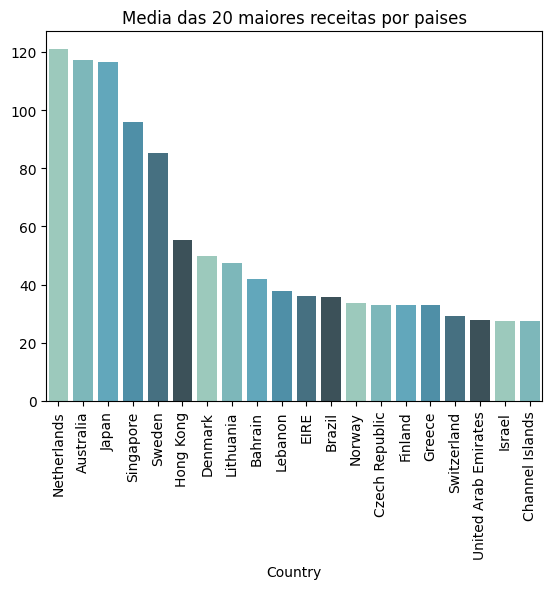

In [12]:
#According to each Country, What is the (Average) Invoice

df_relation['Sales'] = df_relation['Quantity'] * df_relation['UnitPrice']
countries = df_relation[df_relation['Sales']>0].groupby('Country')['Sales'].mean().sort_values(ascending = False)[:20]

sns.barplot(x=countries.index, y=countries.values, palette=sns.color_palette("GnBu_d"))
plt.title("Media das 20 maiores receitas por paises");
plt.xticks(rotation=90);



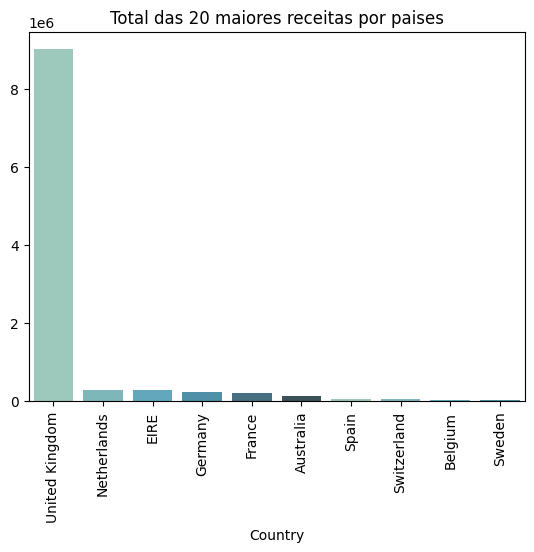

In [13]:
countries = df_relation[df_relation['Sales']>0].groupby('Country')['Sales'].sum().sort_values(ascending = False)[:10]
sns.barplot(x=countries.index, y=countries.values, palette=sns.color_palette("GnBu_d"))
plt.title("Total das 20 maiores receitas por paises");
plt.xticks(rotation=90);